In [1]:
"""
    source: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
"""
import pandas as pd
df = pd.read_csv('complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2020-10-23,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,NaN,JPMORGAN CHASE & CO.,IL,60651,"Older American, Servicemember",NaN,Phone,2020-10-23,In progress,Yes,NaN,3915998
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2020-10-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,334XX,NaN,Other,Web,2020-10-23,Closed with explanation,Yes,NaN,3915909


In [2]:
print("number of rows before sampling: ", len(df.index))

sampleSize = 20000
df = df.sample(sampleSize)

print("number of rows after sampling: ", len(df.index))

number of rows before sampling:  1829149
number of rows after sampling:  20000


In [3]:
#we only need the 'product' and the 'consumer complaint narrative' so we filter them
#  and create a third category creating enumeric representations of the product labels


#col is a filter used to get the columns we need
col = ['Product', 'Consumer complaint narrative']
df = df[col]

#we then erase any rows that contain null values in the narrative
#notnull creates a boolean array which is then fed back into the array indexing of
# df to filter the rows containing null values
df = df[pd.notnull(df['Consumer complaint narrative'])]

#rename the columns for ease of access purposes
df.columns = ['Product', 'Consumer_complaint_narrative']
#create a new column with df.factorize to get a enumeric representation of the products
df['category_id'] = df['Product'].factorize()[0]
#create a relational table to relate the product labels to the created id's
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df.head()

,Product,Consumer_complaint_narrative,category_id
752730,Mortgage,I contacted Chase on XX/XX/XXXX after receivin...,0
469813,"Credit reporting, credit repair services, or o...",XXXX ; Experian and XXXX should not be repor...,1
1443726,Credit card,For inaccurate reporting and failing to proper...,2
724430,Debt collection,"On a letter date XX/XX/18, Ally sent me a bill...",3
31172,Debt collection,Collections from Phoenix Financial Services in...,3


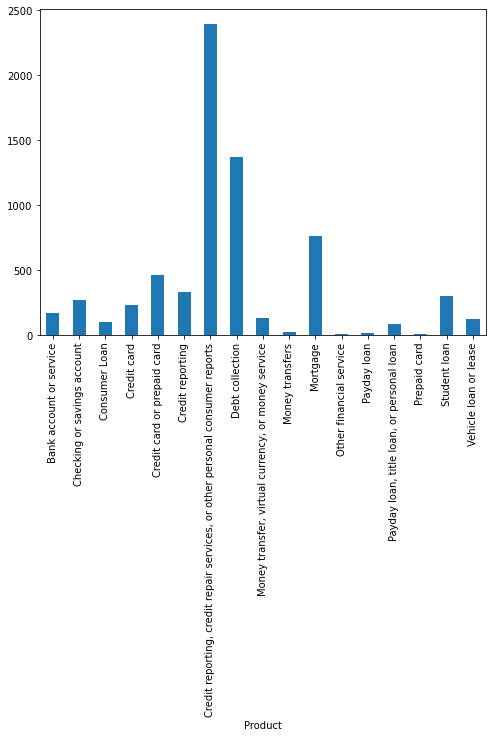

In [4]:
#the number of complaints perproduct is imbalanced. this can create biased training
#  models. however we will not worry about it in this case.

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [5]:
#feature extraction
#here we create a tf-idf bag of words feature vector

from sklearn.feature_extraction.text import TfidfVectorizer

#here we create a tdfidf vectorizer function to process our input
#norm is L2 (the euclidean norm)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                       encoding='latin-1', ngram_range=(1, 2), stop_words='english'
                       )

#we then  use the created tdfidf vectorizer to compute the tf-idf of our bag of 
#    words
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape


(6761, 19620)

In [6]:
#now we can use the chi squared test to find the terms that are most correlated
#  with the products

from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    #print our most relavant features for veiwing
    print("# '{}':".format(Product))
    print(" . Most correlated unigrams: \n. {}".format('\n.'.join(unigrams[-N:])))
    print(" . Most correlated bigrams:\n. {}".format('\n.'.join(bigrams[-N:])))

# 'Bank account or service':
 . Most correlated unigrams: 
. branch
.overdraft
 . Most correlated bigrams:
. branch manager
.overdraft fees
# 'Checking or savings account':
 . Most correlated unigrams: 
. branch
.deposit
 . Most correlated bigrams:
. account bank
.checking account
# 'Consumer Loan':
 . Most correlated unigrams: 
. honda
.toyota
 . Most correlated bigrams:
. vehicle sold
.capital auto
# 'Credit card':
 . Most correlated unigrams: 
. macy
.card
 . Most correlated bigrams:
. annual fee
.credit card
# 'Credit card or prepaid card':
 . Most correlated unigrams: 
. citi
.card
 . Most correlated bigrams:
. american express
.credit card
# 'Credit reporting':
 . Most correlated unigrams: 
. equifax
.experian
 . Most correlated bigrams:
. file used
.tax lien
# 'Credit reporting, credit repair services, or other personal consumer reports':
 . Most correlated unigrams: 
. accounts
.report
 . Most correlated bigrams:
. identity theft
.credit report
# 'Debt collection':
 . Most corr

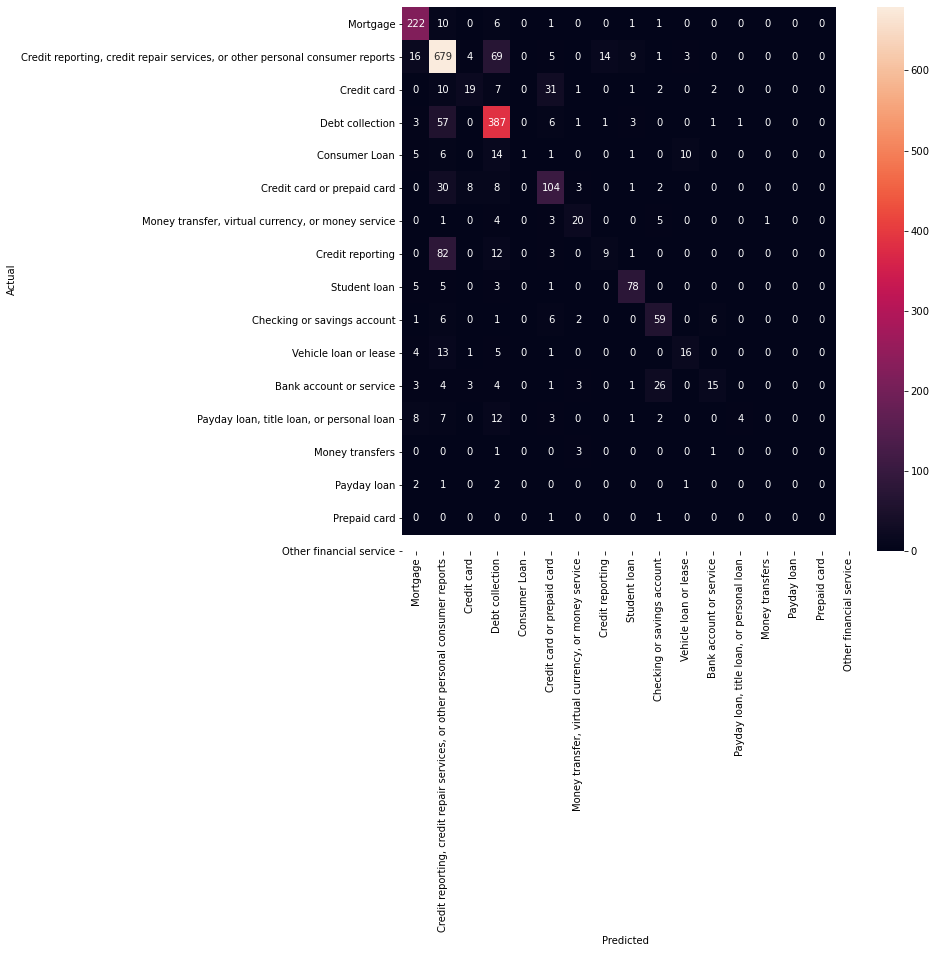

In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))


ValueError: Number of classes, 16, does not match size of target_names, 17. Try specifying the labels parameter